# Linear regression using LASSO

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tueplots import bundles
from tueplots.constants.color import rgb

from utils import get_dataframe, get_astronomical_seasons

Load data:

In [2]:
df = get_dataframe(solar_noon_altitudes=True, interpolate_data=True)

X = df.drop(['RSKF', 'Datum und Uhrzeit', 'Gesamtanlage[kWh]'], axis=1) # Remove categorial feature, date and dependent variable.
features = X.columns

scaler = StandardScaler()
scaler.fit(X)
X_standard = scaler.transform(X) # Standardize the features for correct regularization.

y = df['Gesamtanlage[kWh]']

Train linear regression model:

In [3]:
alpha = 0.3 # Regularization factor
reg = Lasso(alpha).fit(X_standard, y)

coefficients = pd.DataFrame(data=reg.coef_, index=features, columns=['all'])
print(coefficients)

print('Regularization factor: ', alpha)
print('R^2: ', reg.score(X_standard,y))

              all
FX      -0.000000
FM       0.000000
RSK     -0.243778
SDK      7.026082
SHK_TAG  0.000000
NM      -0.000000
VPM     -0.000000
PM      -0.231517
TMK      0.232433
UPM     -0.029030
TXK      0.000000
TNK      0.000000
TGK      0.000000
SNA      7.166691
Regularization factor:  0.3
R^2:  0.9283549403329411


Plotting:

In [14]:
# Code taken from exploratory_analysis.ipynb and adapted:

In [4]:
from datetime import datetime

data = get_dataframe(solar_noon_altitudes=True, interpolate_data=True)
# remove whitespace at beginning of column name
data.columns = [col.strip() for col in data.columns]
data.head()


# drop 29.02.2020 because there is no value in the other years to compare
data = data.drop(data[data['Datum und Uhrzeit'] == '29.02.2020'].index).reset_index()
data = data.drop('index', axis=1)

# add column for year, month and day of the year
# convert 'Datum und Uhrzeit' column to date
data['Date'] = [datetime.strptime(data['Datum und Uhrzeit'][i], '%d.%m.%Y') for i in range(len(data))]
data['Year'] = data['Date'].dt.year
data['Day of year'] = data['Date'].dt.dayofyear
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data.drop('Date', axis=1)

For 2019 the MSE is 11.90.
For 2020 the MSE is 12.13.
For 2021 the MSE is 12.25.
For 2022 the MSE is 14.24.


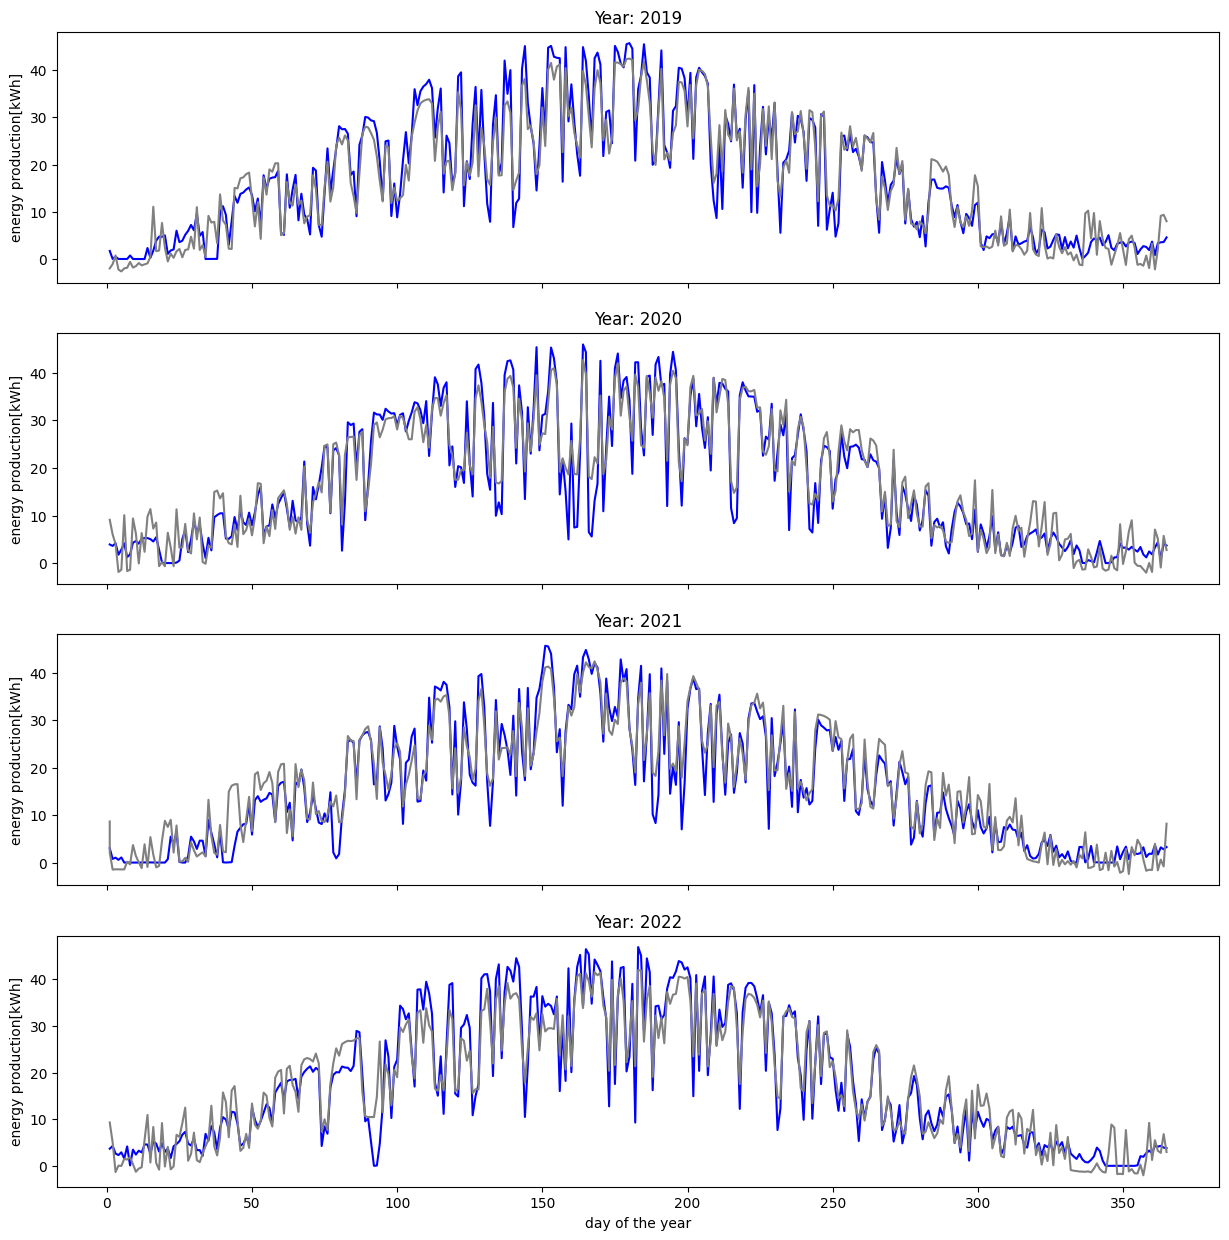

In [5]:
fig, axes = plt.subplots(4, 1, figsize=(15,15), sharex=True)
i = 0
for year in data['Year'].unique():
    ax = axes.flatten()[i]
    ax.set_title('Year: ' + str(year))
    year_data = data[data['Year'] == year]

    X = year_data.drop(['RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Month', 'Day', 'Gesamtanlage[kWh]'], axis=1)
    X = scaler.transform(X)

    # plot energy production
    ax.plot(
        year_data['Day of year'],
        year_data['Gesamtanlage[kWh]'],
        color='blue'
    )

    #plot predictions
    ax.plot(
        year_data['Day of year'],
        reg.predict(X),
        color='grey'
    )
        
    ax.set_ylabel('energy production[kWh]')
    i += 1


    # compute mean squared error:
    mse = mean_squared_error(year_data['Gesamtanlage[kWh]'], reg.predict(X))
    print(f'For {year} the MSE is {mse:.2f}.')

    
axes[3].set_xlabel('day of the year')
plt.show()

Regression for individual seasons:

In [7]:
seasons = ['winter', 'spring', 'summer', 'fall']
data['Season'] = data.apply(get_astronomical_seasons, axis=1)

In [8]:
reg_by_season = {}
X_by_season = {}
y_by_season = {}
scaler_by_season = {}

for season in seasons:

    data_season = data[data['Season'] == season]
    X_season = data_season.drop(['Season', 'RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Day', 'Month', 'Gesamtanlage[kWh]'], axis=1)
    scaler_season = StandardScaler()
    scaler_season.fit(X_season)
    X_season_standard = scaler_season.transform(X_season) # Standardize the features for correct regularization.
    y_season = data_season['Gesamtanlage[kWh]']

    alpha_season = alpha # Same regularization factor
    reg_season = Lasso(alpha_season).fit(X_season_standard, y_season)

    reg_by_season[season] = reg_season
    X_by_season[season] = X_season
    y_by_season[season] = y_season
    scaler_by_season[season] = scaler_season

#### Prepare data for plotting


In [64]:
# https://stackoverflow.com/questions/28931224/how-to-add-value-labels-on-a-bar-chart

# drop features set to zero in every season
for season in seasons:
    weights_temp = reg_by_season[season].coef_
    coefficients[season] = weights_temp


plotting_weights = coefficients.replace(0, np.nan)
plotting_weights = plotting_weights.dropna(how='all', axis=0)
plotting_weights = plotting_weights.replace(np.nan, 0)
plotting_weights.drop(columns=['all'], inplace=True)
plotting_weights['sort_val'] = plotting_weights.sum(axis=1)
plotting_weights = plotting_weights.sort_values(by='sort_val')
plotting_weights = plotting_weights.drop(columns=['sort_val'])


In [65]:
plotting_weights

,winter,spring,summer,fall
UPM,-0.015162,-1.022044,-1.704879,-0.072417
TNK,0.000000,0.000000,-0.427131,0.000000
RSK,0.000000,-0.091461,0.000000,-0.309867
SHK_TAG,-0.283297,0.000000,0.000000,0.000000
VPM,0.000000,0.000000,-0.185912,0.000000
PM,0.000000,0.000000,0.000000,0.000000
TXK,0.444761,0.000000,0.000000,0.071525
TMK,0.000000,1.144819,0.000000,0.052660
SNA,0.613026,4.848156,0.662722,4.309275
SDK,0.588031,5.115485,8.586783,5.751675


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


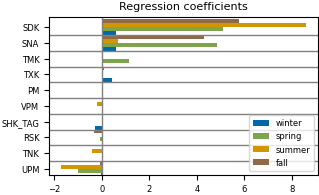

In [70]:
# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))

plotting_features = list(plotting_weights.index)
colors=[rgb.tue_blue, rgb.tue_green, rgb.tue_orange, rgb.tue_brown]

x = np.arange(plotting_weights.shape[0])  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for f, w in plotting_weights.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, w.values, width, label=f, color=colors[multiplier])
    multiplier += 1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Regression coefficients')
ax.set_yticks(x + (width * 1.5), plotting_features)
ax.legend(loc='lower right', ncols=1)
ax.axvline(x = 0, color = 'gray', lw=1)
for y in x:
    ax.axhline(y=y-(width*0.5), color='gray', lw=1)
    
plt.ylim((0,10))
plt.savefig('../report/fig/regression.pdf')
plt.show()

In [ ]:
def reg_using_season(row):
    season = row['Season']
    sample = row.drop(['Season'])
    sample = scaler_by_season[season].transform(pd.DataFrame([sample]))
    return reg_by_season[season].predict(sample)

For 2019 the MSE is 7.34.
For 2020 the MSE is 6.45.
For 2021 the MSE is 6.98.
For 2022 the MSE is 9.09.


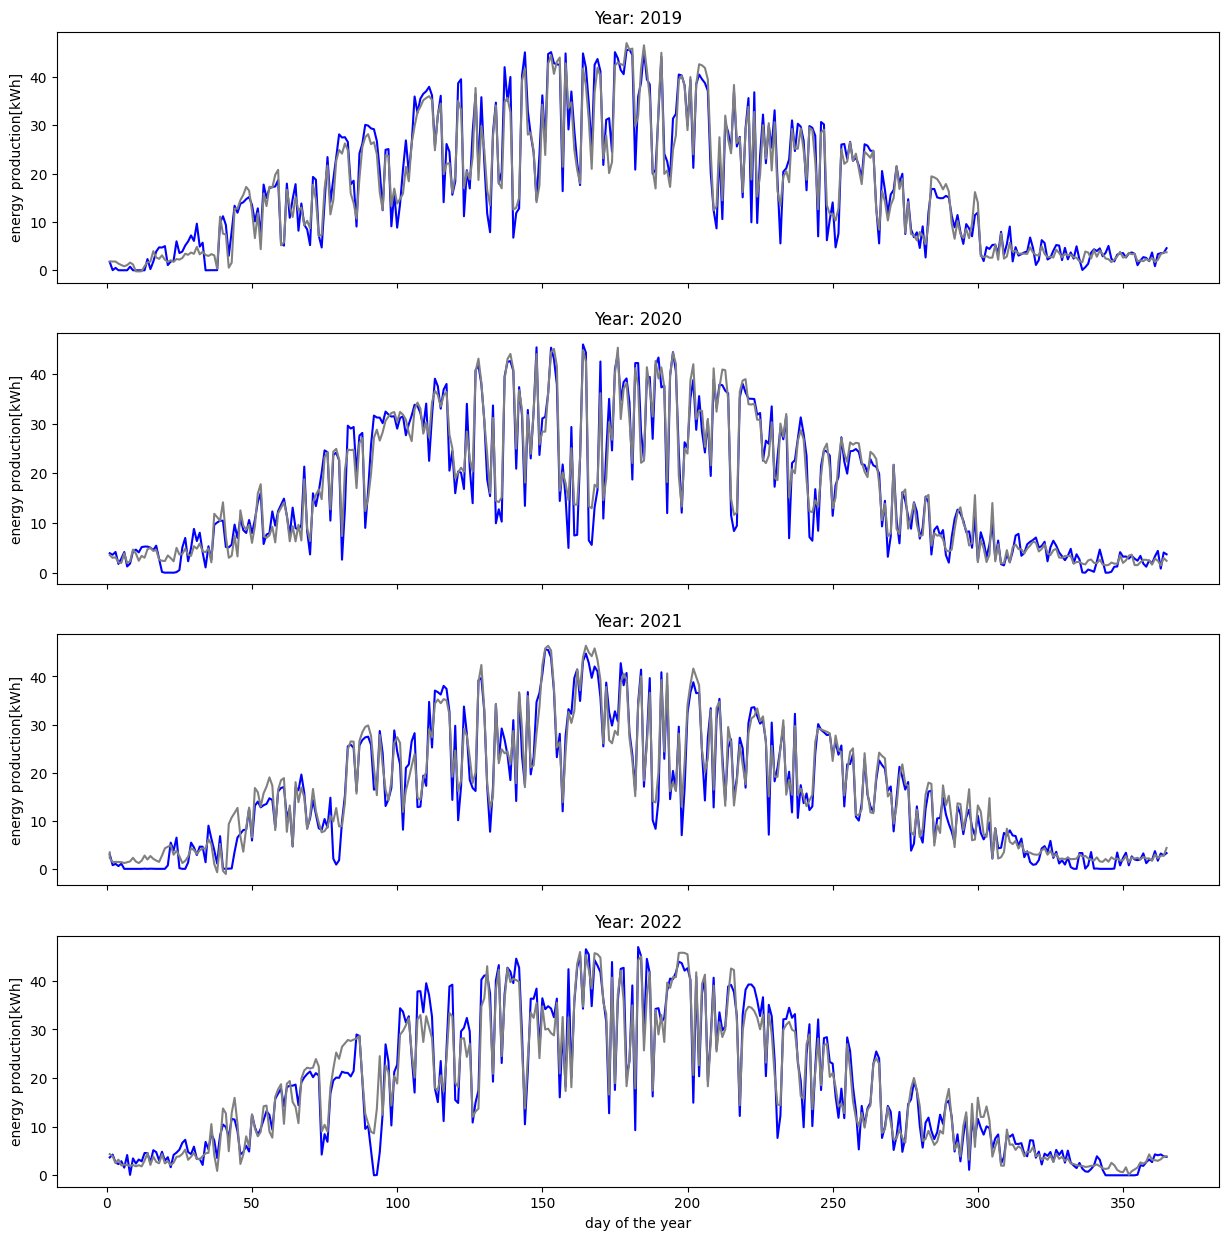

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(15,15), sharex=True)
i = 0

for year in data['Year'].unique():
    ax = axes.flatten()[i]
    ax.set_title('Year: ' + str(year))
    year_data = data[data['Year'] == year]

    # plot energy production
    ax.plot(
        year_data['Day of year'],
        year_data['Gesamtanlage[kWh]'],
        color='blue'
    )

    X = year_data.drop(['RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Day', 'Month', 'Gesamtanlage[kWh]'], axis=1)
    pred_using_season = X.apply(reg_using_season, axis=1)

    #plot predictions
    ax.plot(
        year_data['Day of year'],
        pred_using_season,
        color='grey'
        )
        
    ax.set_ylabel('energy production[kWh]')
    i += 1


    # compute mean squared error:
    mse = mean_squared_error(year_data['Gesamtanlage[kWh]'], pred_using_season)
    print(f'For {year} the MSE is {mse:.2f}.')

    
axes[3].set_xlabel('day of the year')
plt.show()